In [33]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [60]:
class ThaApp:
    
    def __init__(self, filename):
        self.img = cv2.imread(f)
        self.prev = [0]*7
        self.dots_list = [0]*6
        self.index = 0
        self.teardrop_edges = []
        self.midpt = (0, 0)
        self.s = 0
        self.gamma = 0
        self.ratio = 0
        self.beta = 0
        self.draw = True 

    def calc_angle(self, pt1, pt2):
        """
        Calculate angle between two points, if pt1 is
        left of pt2. Use tan of angle = opposite/adjacent.
        """ 
        y = pt2[1]-pt1[1]
        x = pt2[0]-pt1[0]
        return np.arctan(y/x)

    def rotate(self, origin, point, angle):
        """
        Rotate point CCW by a given angle around a given origin.
        The angle should be given in radians.
        """
        ox, oy = origin
        px, py = point

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        return (qx, qy)

    def midpoint(self, v1, v2):
        # get midpoint between 2 points
        return ((v1[0]+v2[0])/2, (v1[1]+v2[1])/2)

    def minor_axis(self, dots_list):
        """
        For an ellipse aligned with the x-axis, solve for the
        length of its minor axis. The equation for an ellipse
        with center (h,k): (x-h)2/a2 + (y-k)2/b2 = 1 
        """
        x = dots_list[2][0]
        y = dots_list[2][1]
        h = self.midpt[0]
        k = self.midpt[1]
        a = abs(self.midpt[0]-dots_list[0][0]) 
        b =(-(a**2*(y-k)**2)/((x-h)**2-a**2))**0.5
        return b

    def ellipse(self, dots_list):
        """
        """
        # Get midpoint between 2 ends of major axis
        self.midpt = self.midpoint(dots_list[0], dots_list[1])
        # Calculate angle to align major axis with x-axis
        # Return the negative since the axes are flipped (CCW is opposite direction)
        angle = -self.calc_angle(dots_list[0], dots_list[1])
        # Rotate each point of dots list 
        new_dots_list = []
        for pt in dots_list:
            new_dots_list.append(self.rotate(self.midpt, pt, angle))
        major_axis_length = math.dist(dots_list[0], dots_list[1])
        minor_axis_length = self.minor_axis(new_dots_list)*2
        self.s = minor_axis_length
        axes = (int(major_axis_length/2), int(minor_axis_length/2))
        int_midpt = (int(self.midpt[0]), int(self.midpt[1]))
        # Return the negative of the angle since ellipse is clockwise
        cv2.ellipse(self.img, int_midpt, axes, -np.degrees(angle), 0, 360, (255, 0, 0), 5)
        self.measure_gamma()

    def dots_of_mouse(self, mouse_click,x_cor,y_cor,flag_var,param):
        """
        Function to draw a dot on image whenever we click 
        """
        if mouse_click == cv2.EVENT_LBUTTONDOWN and self.index < 6: 
            if self.index in [1, 3]:
                cv2.line(self.img,tuple(self.dots_list[self.index-1]),(x_cor,y_cor),(0,0,255),2)
            cv2.circle(self.img,(x_cor,y_cor),5,(0,0,255),cv2.FILLED)
            self.dots_list[self.index] = [x_cor,y_cor]
            self.index += 1
        elif mouse_click == cv2.EVENT_LBUTTONDOWN and self.index == 6: 
            self.draw = False
    
    def end_pt(self, mouse_click,x_cor,y_cor,flag_var,param):
        if mouse_click == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(self.img, (x_cor, y_cor), 5, (0,0,255), cv2.FILLED)
            self.dots_list[self.index] = [x_cor, y_cor]
            self.index += 1 
    
    def get_vec(self, a,b):
        return [b[0]-a[0], b[1]-a[1]]

    def measure_gamma(self):
        v1 = self.get_vec(self.dots_list[0], self.dots_list[1])
        v2 = self.get_vec(self.dots_list[2], self.dots_list[3])
        dotp = np.dot(v1, v2)
        mag1 = np.dot(v1, v1)**0.5
        mag2 = np.dot(v2, v2)**0.5
        self.gamma = np.arccos(dotp/mag2/mag1)

    def draw_perp(self, v1, v2):
        m = -(v1[0]-v2[0])/(v1[1]-v2[1]) # Perpendicular slope
        x1 = self.midpt[0] - self.midpt[1]/m
        int_midpt = (int(self.midpt[0]), int(self.midpt[1]))
        cv2.line(self.img, int_midpt, (int(x1), 0), (0,0,255), 2)
        
    def extend_line(self, p1, p2, distance=10000):
        diff = np.arctan2(p1[1] - p2[1], p1[0] - p2[0])
        p3_x = int(p1[0] + distance*np.cos(diff))
        p3_y = int(p1[1] + distance*np.sin(diff))
        p4_x = int(p1[0] - distance*np.cos(diff))
        p4_y = int(p1[1] - distance*np.sin(diff))
        return ((p3_x, p3_y), (p4_x, p4_y))
        
    def draw_parallel(self, v1, v2):
        m = (v1[1]-v2[1])/(v1[0]-v2[0]) # Parallel slope
        h = self.img.shape[0] # y - y1 = m(x - x1), (x, y) = (0, y)
        y1 = int(-m * v1[0] + v1[1])
        y2 = int(m * (h - v1[0]) + v1[1])
        self.teardrop_edges = self.extend_line((0, y1), (h, y2))
        cv2.line(self.img, self.teardrop_edges[0], self.teardrop_edges[1], (0, 0, 255), 2)
        
    def measure_beta(self):
        tl = math.dist(self.midpt, self.dots_list[-1])+self.s/2
        self.ratio = self.s/2/tl  # Fix - what is s? 
        csc = 1/np.sin(self.gamma)
        isin = np.arcsin(self.ratio/(2-self.ratio))
        tan = np.tan(isin*csc)
        alpha = np.arctan(tan) 
        tan1 = np.tan(alpha + 5.46*math.pi/180) 
        self.beta = math.degrees(np.arctan(tan1*np.sin(self.gamma)))
        cv2.putText(self.img,str(self.beta),(250,650),cv2.FONT_HERSHEY_COMPLEX,
                1,(0,0,255),2)
    
    def fix(self):
        if cv2.waitKey(1) & 0xFF == ord('u'): # undo move
            self.index -= 1 
            if (self.index) >= 0:  
                self.img = self.prev[self.index].copy()
        
        elif cv2.waitKey(1) & 0xFF == ord('r'): # redo move 
            if type(self.prev[self.index + 1]) != int:
                self.index += 1  
                self.img = self.prev[self.index].copy()
        
        elif cv2.waitKey(1) & 0xFF == ord('q'): # clear everything 
            self.index = 0
            self.img = cv2.imread(f)
            self.prev = [0]*7
            self.dots_list = [0]*6
    
    def print_to_excel(self):
        columns = ['Abduction Angle', 'S/L', 'Anteversion (Widmer)', 'Anteversion (Liaw)']
        ant = 48.05*self.ratio-0.3
        data = [self.gamma*180/np.pi, self.ratio, ant, self.beta]
        df = pd.DataFrame(data=[data], columns=columns)
    
    def start(self):
        plt.imshow(self.img)

        while self.draw:
            if self.index >= 2:  
                self.draw_parallel(self.dots_list[0], self.dots_list[1])
            if self.index >= 5: 
                self.ellipse(self.dots_list[2:5])
                self.draw_perp(self.dots_list[2], self.dots_list[3])
            if self.index == 6: 
                cv2.setMouseCallback('Image', self.end_pt)
                self.measure_beta()
                self.print_to_excel() 
            cv2.imshow('Image', self.img)
            cv2.setMouseCallback('Image', self.dots_of_mouse)
            self.prev[self.index] = self.img.copy()
            self.fix()

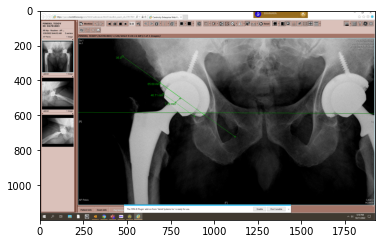

In [61]:
f = 'Downloads/image.png'
x = ThaApp(f)
x.start()

In [18]:
img = cv2.imread(f)
img.shape

(1200, 1920, 3)

AttributeError: module 'cv2' has no attribute 'help'